## 02: Data Preparation

1. Here we construct our dataset for use in the experiment.

In [1]:
# import required libraries
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import libs.utils as utils
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
import libs.data_prep as data_prep
import libs.train_test_split as tts
import libs.importing as importing
import libs.render as render
import libs.stats as stats
import libs.patch_tools as patch_tools
from importlib import reload


# set the random seed for we always get the same results (for now)
random.seed(42)


In [3]:
# GENERATE DATASET ID
exp_id = utils.short_id()
# use same data
exp_id = '315f7638'
print('ID: {}'.format(exp_id))

ID: 315f7638


In [4]:
# COPY DATA and SETUP EXPERIMENT
base_dir = '../source_dataset/all_v1'
data_prep.setup_experiment(base_dir, exp_id)

In [19]:
# 2-CLASS PROBLEM : Benign v. Papilloma

# SETUP : GET ALL CONTOURS
roi_df = pd.read_csv(os.path.join(exp_id, 'contours.csv'))
roi_2class = roi_df.copy()

# SELECT : only benign and papilloma labeled contours
roi_2class = roi_2class[roi_2class.label.isin([2,3,4])].reset_index(drop=True)

# combine all dysplasias and carcinoma
roi_2class.loc[roi_2class['label'] == 4, 'label'] = 3
roi_2class.loc[roi_2class['label'] == 2, 'label'] = 1
roi_2class.loc[roi_2class['label'] == 3, 'label'] = 2

train2bp_df, test2bp_df, val2bp_df = tts.train_test_validation_split(roi_2class, classes=[1,2], samples=3)

# SAVE : save the results
train2bp_df.to_csv(os.path.join(exp_id, 'contours_train.csv'), index=False)
test2bp_df.to_csv(os.path.join(exp_id, 'contours_test.csv'), index=False)
val2bp_df.to_csv(os.path.join(exp_id, 'contours_val.csv'), index=False)

n: 67
distribution: [1 2] [20 47]
classes: [1 2], samples_per_class: 3
train-n: 55
test-n: 6
val-n: 6


In [7]:
# OR IF we've already run this notebook before we can just load the data
train2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
test2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
val2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))

In [20]:
# LOG : show all the contours we dumped and those we are using
#       these are logged at: 
#       [dumped] ./exp_id/log/eleminated_contours
#       [kept]   ./exp_id/log/experiment_contours
data_prep.show_contours_for_experiment(exp_id, roi_df, roi_2class)

total contours: 97
eliminated contours: 30
kept contours: 67


image_id        id          name  label
0   hgv-44a1f2e3  3cde1351  3cde1351.csv      1
1   hgv-2d4a6a46  76f536d8  76f536d8.csv      1
2   hgv-8528141b  54a3553b  54a3553b.csv      1
3   hgv-8528141b  4cb5eb92  4cb5eb92.csv      1
4   hgv-8528141b  9be9ecb7  9be9ecb7.csv      1
5   hgv-8528141b  96c7cdbf  96c7cdbf.csv      1
6   hgv-453fea32  12acd19b  12acd19b.csv      1
7   hgv-99fc12a1  2bde738d  2bde738d.csv      1
8   hgv-de605528  edc49bcb  edc49bcb.csv      1
9   hgv-1cc11649  ff439444  ff439444.csv      1
10  hgv-1cc11649  cb636c4e  cb636c4e.csv      1
11  hgv-ff91c0a9  b99d3094  b99d3094.csv      1
12  mdi-e3b0c312  d20913b2  d20913b2.csv      1
13  mdi-461bdebc  1a97162b  1a97162b.csv      1
14  mdi-945f5ac6  09c29991  09c29991.csv      1
15  mdi-f5cb6906  31058c3b  31058c3b.csv      1
16  mdi-df9a656f  a688c428  a688c428.csv      1
17  mdi-b731a91f  89d225d4  89d225d4.csv      1
18  mdi-5e3d3832  4963cf18  4963cf18.csv      1
19  mdi-f3f9ede5  f64de600  f64de600.csv      1
20  odi-963ee4be  ed29c1cd  ed29c1cd.csv      1
21  odi-1767f1a2  f92bbc3e  f92bbc3e.csv      1
22  odi-1767f1a2  ed6f6fc4  ed6f6fc4.csv      1
23  odi-7a9f9582  0ef94ef9  0ef94ef9.csv      1
24  odi-2511b830  481d2a42  481d2a42.csv      1
25  odi-423f2ec2  d3d5d3cb  d3d5d3cb.csv      1
26  odi-28084697  bc1de0a8  bc1de0a8.csv      1
27  odi-b43ee406  057317a5  057317a5.csv      1
28  odi-1480976d  c9405b0b  c9405b0b.csv      1
29  odi-897669a0  711ca824  711ca824.csv      1

In [21]:
# TRAIN : data setup
#       : creates a directory ./exp_id/train/  where all the images and contours for training are stored
#       : creates a directory ./exp_id/train/log/info, where the contours and labels for the training set are stored as images for debugging purposes. 
train_df  = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
data_prep.setup_component(exp_id, train_df, 'train')
data_prep.log_component_info(os.path.join(exp_id, 'train'))

In [22]:
# TEST : data setup
#       : creates a directory ./exp_id/test/  where all the images and contours for test data are stored
#       : creates a directory ./exp_id/test/log/info, where the contours and labels for the test set are stored as images for debugging purposes.
test_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
data_prep.setup_component(exp_id, test_df, 'test')
data_prep.log_component_info(os.path.join(exp_id, 'test'))

In [23]:
# VALIDATION : data setup
#       : creates a directory ./exp_id/val/  where all the images and contours for validation data are stored
#       : creates a directory ./exp_id/val/log/info, where the contours and labels for the validation set are stored as images for debugging purposes.
val_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))
data_prep.setup_component(exp_id, val_df, 'val')
data_prep.log_component_info(os.path.join(exp_id, 'val'))

In [24]:
# GENERATE PATCHES : training data
#                    logs information to ./exp_id/train/log/setup_patches, where it shows patches on the image before and after removal

# threshold : the percentage a patch needs to overlap with the contour polygon in order to not be discarded
# patch_overlap : the shift size, should be a value which generates a factor of 64 for instance 0.5*64 = 32, or 0.25 * 64 = 16, etc.
train_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'train'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

# inspect the structure of our patches.csv file
display(train_patches_df.head())

# see how many training patches we have 
print('count: {}'.format(len(train_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-44a1f2e3   2dd43905  dc2d2b23  dc2d2b23.jpg  762  674        2
1  hgv-44a1f2e3   2dd43905  9eb95c97  9eb95c97.jpg  794  674        2
2  hgv-44a1f2e3   2dd43905  e02f449f  e02f449f.jpg  826  674        2
3  hgv-44a1f2e3   2dd43905  c9f16964  c9f16964.jpg  858  674        2
4  hgv-44a1f2e3   2dd43905  9bc704ba  9bc704ba.jpg  890  674        2

count: 3143


In [25]:
# GENERATE PATCHES : test data
#                    logs information to ./exp_id/test/log/setup_patches, where it shows patches on the image before and after removal
test_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'test'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(test_patches_df.head())
print('count: {}'.format(len(test_patches_df)))

image_id contour_id  patch_id    patch_name     x    y label_id
0  hgv-2d4a6a46   2a8db1fa  1ff4c084  1ff4c084.jpg  1464  536        1
1  hgv-2d4a6a46   2a8db1fa  23cecce1  23cecce1.jpg  1432  568        1
2  hgv-2d4a6a46   2a8db1fa  51a55c7d  51a55c7d.jpg  1464  568        1
3  hgv-2d4a6a46   2a8db1fa  9540ce50  9540ce50.jpg  1496  568        1
4  hgv-2d4a6a46   2a8db1fa  1225b07b  1225b07b.jpg  1400  600        1

count: 256


In [26]:
# GENERATE PATCHES : validation data
#                    logs information to ./exp_id/val/log/setup_patches, where it shows patches on the image before and after removal
val_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'val'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(val_patches_df.head())
print('count: {}'.format(len(val_patches_df)))

image_id contour_id  patch_id    patch_name     x    y label_id
0  hgv-8528141b   0f887b7a  8d87b70c  8d87b70c.jpg  1131  486        1
1  hgv-8528141b   0f887b7a  48b1e0f9  48b1e0f9.jpg  1163  486        1
2  hgv-8528141b   0f887b7a  6bfddf54  6bfddf54.jpg  1195  486        1
3  hgv-8528141b   0f887b7a  c32cf49c  c32cf49c.jpg  1099  518        1
4  hgv-8528141b   0f887b7a  1b52f75f  1b52f75f.jpg  1131  518        1

count: 388


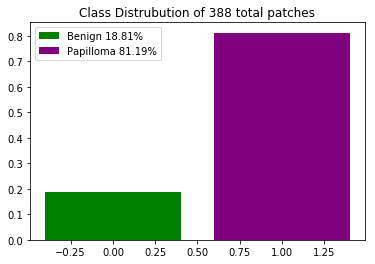

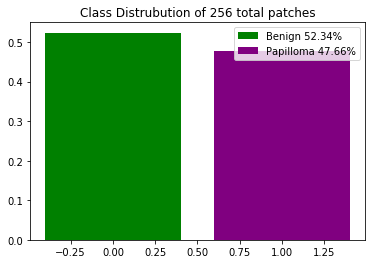

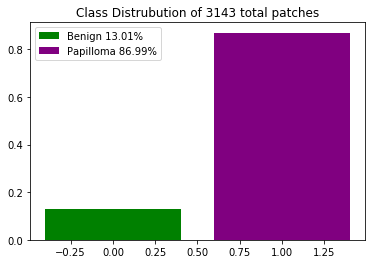

In [27]:
# BEFORE FILTERING PATCHES LOOK AT PATCH DISTRIBUTION
stats.plot_label_distribution(val_patches_df, labels=[1,2], label_key='label_id')
stats.plot_label_distribution(test_patches_df, labels=[1,2], label_key='label_id')
stats.plot_label_distribution(train_patches_df, labels=[1,2], label_key='label_id')

In [28]:
# FILTER PATCHES : some patches have way too much light or are just bad quality
#                  here we filter out patches which are so specular they contain very little information
#                  see: filtered patches are drawn onto the image at : ./exp_id/{train,test,val}/log/filter_highlight_patches - useful for debugging

train_dir = os.path.join(exp_id, 'train')
test_dir = os.path.join(exp_id, 'test')
val_dir = os.path.join(exp_id, 'val')

data_prep.filter_highlight_patches_for(train_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(test_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(val_dir, patch_size = 64, threshold=0.5)


bad patches: 50
before: 3143
cleaned: 3093
bad patches: 0
before: 256
cleaned: 256
bad patches: 3
before: 388
cleaned: 385


image_id contour_id  patch_id    patch_name     x    y  label_id
0    hgv-8528141b   0f887b7a  8d87b70c  8d87b70c.jpg  1131  486         1
1    hgv-8528141b   0f887b7a  48b1e0f9  48b1e0f9.jpg  1163  486         1
2    hgv-8528141b   0f887b7a  6bfddf54  6bfddf54.jpg  1195  486         1
3    hgv-8528141b   0f887b7a  c32cf49c  c32cf49c.jpg  1099  518         1
4    hgv-8528141b   0f887b7a  1b52f75f  1b52f75f.jpg  1131  518         1
5    hgv-8528141b   0f887b7a  b62f2f4c  b62f2f4c.jpg  1163  518         1
6    hgv-8528141b   0f887b7a  c380f701  c380f701.jpg  1195  518         1
7    hgv-8528141b   0f887b7a  6c0f14fa  6c0f14fa.jpg  1227  518         1
8    hgv-8528141b   0f887b7a  d7b823af  d7b823af.jpg  1067  550         1
9    hgv-8528141b   0f887b7a  e1c3d23d  e1c3d23d.jpg  1099  550         1
10   hgv-8528141b   0f887b7a  9bd5fa09  9bd5fa09.jpg  1131  550         1
11   hgv-8528141b   0f887b7a  972d65af  972d65af.jpg  1163  550         1
12   hgv-8528141b   0f887b7a  ccd1f0f2  ccd1f0f2.jpg  1195  550         1
13   hgv-8528141b   0f887b7a  bdbdce4a  bdbdce4a.jpg  1227  550         1
14   hgv-8528141b   0f887b7a  3af4bf85  3af4bf85.jpg  1259  550         1
15   hgv-8528141b   0f887b7a  621d37a9  621d37a9.jpg  1067  582         1
16   hgv-8528141b   0f887b7a  18ec3e0c  18ec3e0c.jpg  1099  582         1
17   hgv-8528141b   0f887b7a  17aa6145  17aa6145.jpg  1131  582         1
18   hgv-8528141b   0f887b7a  2a822118  2a822118.jpg  1163  582         1
19   hgv-8528141b   0f887b7a  2ccd9bc2  2ccd9bc2.jpg  1195  582         1
20   hgv-8528141b   0f887b7a  a35c3f55  a35c3f55.jpg  1227  582         1
21   hgv-8528141b   0f887b7a  04273c37  04273c37.jpg  1259  582         1
22   hgv-8528141b   0f887b7a  dc804ee1  dc804ee1.jpg  1067  614         1
23   hgv-8528141b   0f887b7a  2678c321  2678c321.jpg  1099  614         1
24   hgv-8528141b   0f887b7a  a188fbad  a188fbad.jpg  1131  614         1
25   hgv-8528141b   0f887b7a  e59a7fb0  e59a7fb0.jpg  1163  614         1
26   hgv-8528141b   0f887b7a  a70ac0bd  a70ac0bd.jpg  1195  614         1
27   hgv-8528141b   0f887b7a  5109e87d  5109e87d.jpg  1227  614         1
28   hgv-8528141b   0f887b7a  bee49efe  bee49efe.jpg  1259  614         1
29   hgv-8528141b   0f887b7a  26072aa0  26072aa0.jpg  1067  646         1
..            ...        ...       ...           ...   ...  ...       ...
358  odi-0294ae4c   3f7e68a5  e41181ca  e41181ca.jpg   278  488         2
359  odi-0294ae4c   3f7e68a5  18c3f5be  18c3f5be.jpg   310  488         2
360  odi-0294ae4c   3f7e68a5  acb25d73  acb25d73.jpg   342  488         2
361  odi-0294ae4c   3f7e68a5  2f1a1832  2f1a1832.jpg   374  488         2
362  odi-0294ae4c   3f7e68a5  65df18db  65df18db.jpg   406  488         2
363  odi-0294ae4c   3f7e68a5  93b073d8  93b073d8.jpg   438  488         2
364  odi-0294ae4c   3f7e68a5  4a0c5e0e  4a0c5e0e.jpg   470  488         2
365  odi-0294ae4c   3f7e68a5  7c26a205  7c26a205.jpg   246  520         2
366  odi-0294ae4c   3f7e68a5  83b3341b  83b3341b.jpg   278  520         2
367  odi-0294ae4c   3f7e68a5  3286134f  3286134f.jpg   310  520         2
368  odi-0294ae4c   3f7e68a5  4dc3b01c  4dc3b01c.jpg   342  520         2
369  odi-0294ae4c   3f7e68a5  c6086947  c6086947.jpg   374  520         2
370  odi-0294ae4c   3f7e68a5  1b91796d  1b91796d.jpg   406  520         2
371  odi-0294ae4c   3f7e68a5  39483088  39483088.jpg   438  520         2
372  odi-0294ae4c   3f7e68a5  10668e9e  10668e9e.jpg   470  520         2
373  odi-0294ae4c   3f7e68a5  7b636fea  7b636fea.jpg   502  520         2
374  odi-0294ae4c   3f7e68a5  f65df0c3  f65df0c3.jpg   310  552         2
375  odi-0294ae4c   3f7e68a5  75bc1c29  75bc1c29.jpg   342  552         2
376  odi-0294ae4c   3f7e68a5  6f0957c2  6f0957c2.jpg   374  552         2
377  odi-0294ae4c   3f7e68a5  7dbd92e3  7dbd92e3.jpg   406  552         2
378  odi-0294ae4c   3f7e68a5  dfab3ed6  dfab3ed6.jpg   438  552         2
379  odi-0294ae4c   3f7e68a5  8b25dd4e  8b25dd4e.jpg   470  552         2
380  odi-0294

In [29]:
## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

train_pdr = importing.PatchDataReader(os.path.join(train_dir, 'patches'), trainp_df)
test_pdr = importing.PatchDataReader(os.path.join(test_dir, 'patches'), testp_df)
val_pdr = importing.PatchDataReader(os.path.join(val_dir, 'patches'), valp_df)

train_img, train_labels = train_pdr.read_data()
test_img, test_labels = test_pdr.read_data()
val_img, val_labels = val_pdr.read_data()

display('train images: {}'.format(len(train_img)))
display('train labels: {}'.format(len(train_labels)))
display('test images: {}'.format(len(test_img)))
display('test labels: {}'.format(len(test_labels)))
display('val images: {}'.format(len(val_labels)))
display('val labels: {}'.format(len(val_img)))


'train images: 3093'

'train labels: 3093'

'test images: 256'

'test labels: 256'

'val images: 385'

'val labels: 385'

In [30]:
# CREATE SHUFFLED DATA

## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

idxs = data_prep.shuffle_indices(len(trainp_df))
shuffled_train_df = trainp_df.loc[idxs].reset_index(drop=True)
shuffled_train_df.to_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(testp_df))
shuffled_test_df = testp_df.loc[idxs].reset_index(drop=True)
shuffled_test_df.to_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(valp_df))
shuffled_val_df = valp_df.loc[idxs].reset_index(drop=True)
shuffled_val_df.to_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'), index=False)



In [17]:
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_pdr)
data_prep.log_patch_data_reader(test_dir, test_pdr)
data_prep.log_patch_data_reader(val_dir, val_pdr)